# Making sense of models using visualization

## Background

- Machine learning models usually work in different ways from human beings, e.g., we don't design programming languages directly on Turing machine, most of them are more towards human languages.
- But human and machine intelligence do share common elements, e.g., hierarchy of abstractions, shared features/concepts for different problems, and the assumption that most problems can be solved by divide-and-conquer.
- We look for techniques that help make the model decisions more transparent to human beings, specifically.
    - what features/concepts a model is using?
    - how the features are related to their decisions?   
- it is 
    - interesting because it gives insights on how intelligence can be constructed in different ways.
    - useful because we still don't know why some models designed by us are working today. :) Even though we claim that ["NO Need to Worry about Adversarial Examples in Object Detection in Autonomous Vehicles"](https://arxiv.org/pdf/1707.03501.pdf)

## What is covered here
- some discussed methods to visualize two types of models
    - CNN for image classification
    - RNN for seq2seq modelling
- active research topic, look up online for more fun, e.g. [here](https://github.com/yosinski/deep-visualization-toolbox)

## Visualize CNN
- VGG16 as an example - clear structure of conv/pool layers that can be explained as image features

### load pretrained VGG16 from [torchvision model zoo](https://github.com/pytorch/vision)
- typical structure of layers of bottleneck features, followed by fully connected classifier layer
- new models might have different structures, e.g., [squeezenet](https://arxiv.org/abs/1602.07360) (squeeze/expand layers), [full-cnn](https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf) (no more fully-connected layer). Some techniques may need twists for them.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import random
import matplotlib.pyplot as plt
import urllib
from io import BytesIO
from PIL import Image
import pandas as pd
from tqdm import tqdm_notebook
from scipy.misc import imresize

import torch
from torch.autograd import Variable
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from torchvision import models, transforms

%matplotlib inline

In [2]:
## helper function for display image grid
def display_grid(img_grid, how="mat", cmap=None, img_sz=1.5):
    """img_grid: np.array of size(n_images, w, h)
    """
    nimg = img_grid.shape[0]
    ncol = int(np.sqrt(nimg))
    nrow = int(np.ceil(nimg / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=(img_sz*nrow, img_sz*ncol))
    if nimg > 1:
        axes = axes.ravel()
    else:
        axes = [axes]
    fig.tight_layout()
    fig.subplots_adjust(hspace=0, wspace=0)
    
    for i in range(nimg):
        if how == "mat":
            axes[i].matshow(img_grid[i, :, :], cmap=cmap)
        else:
            axes[i].imshow(img_grid[i, ...], cmap=cmap)
        axes[i].set_axis_off()

In [3]:
vgg16 = models.vgg16(pretrained=True).cuda()
vgg16

VGG (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pa

Some helper functions

In [4]:
## read ImageNet class names
class_names = urllib.request.urlopen("https://raw.githubusercontent.com/dolaameng/data/master/synset_words.txt").readlines()
class_names = [line.decode("utf-8").strip().split(" ", 1)[-1] for line in class_names]

## image preprocessing for image net models
preprocess = transforms.Compose([
    transforms.Scale([224, 224]),
#     transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.485, .456, .406],
                         std=[.229, .224, .225])
])

postprocess = transforms.ToPILImage()

img2var = lambda img: Variable(preprocess(img).unsqueeze(dim=0)).cuda()
var2img = lambda var: postprocess(var.cpu().data).squeeze().numpy()

## get top n predictions
def top_n_classes(predictions, n=5):
    predictions = predictions.data.cpu().numpy().squeeze()
    classes = np.argsort(predictions)[::-1][:n]
    return pd.DataFrame({"names": [class_names[c] for c in classes], "class": classes})

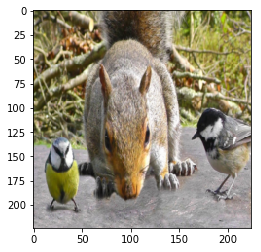

In [5]:
## get an image to test
img_url = 'http://cdn8.openculture.com/wp-content/uploads/2015/11/13212252/cat-and-dog-videos.jpg'
img_bytes = urllib.request.urlopen(img_url).read()
img = Image.open(BytesIO(img_bytes))
plt.imshow(imresize(img, [224, 224]))

In [54]:
## test the model 
img_var = img2var(img)

vgg16.eval()
predictions = vgg16(img_var)
top5 = top_n_classes(predictions, n=5)
top5

,class,names
0,987,corn
1,85,quail
2,11,"goldfinch, Carduelis carduelis"
3,335,"fox squirrel, eastern fox squirrel, Sciurus niger"
4,998,"ear, spike, capitulum"


### CNN Visualization 1 - output of hidden layers
- most straightforward to do is just to visualize the output of hidden layers
- intuitively the outputs of lower layers are closer to input images, whereas the higher layers are closer to output class predictions
- pros:
    - directly showing how images are passing through the model
    - to a certain layer, it shows low-level image features such as corners, edges and etc
- cons
    - the higher the layer, the harder to explain
    - but actually the higher layers have richer information towards the model decision

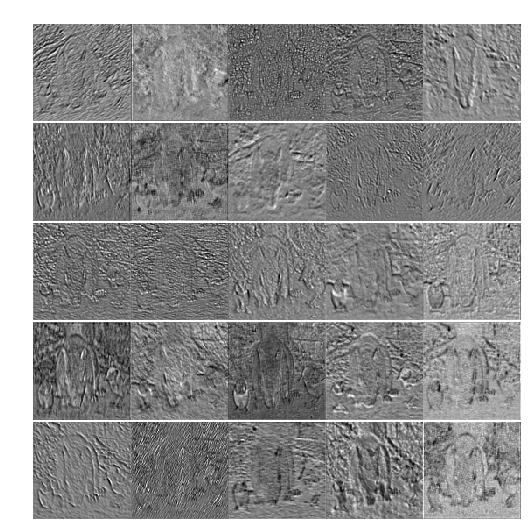

In [7]:
def partial_model(model, ith_layer):
    conv_layers = list(vgg16.children())[0]
    conv_model = nn.Sequential(*[conv_layers[i] for i in range(ith_layer+1)])
    return conv_model

conv7_model = partial_model(vgg16, 7)
conv7_model.eval()
conv7_output = conv7_model(img_var)
conv7_output_data = conv7_output.cpu().data.numpy().squeeze()
display_grid(conv7_output_data[:25], cmap=plt.cm.gray)

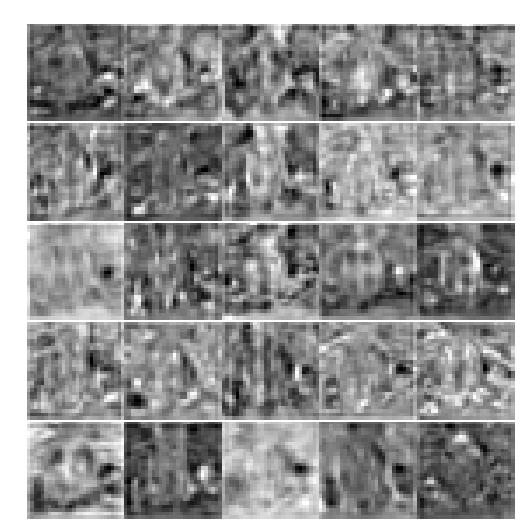

In [47]:
conv21_model = partial_model(vgg16, 21)
conv21_model.eval()
conv21_output = conv21_model(img_var)
conv21_output_data = conv21_output.cpu().data.numpy().squeeze()
display_grid(conv21_output_data[-25:], cmap=plt.cm.gray)

### CNN visualization 2 - inputs that activate certain hidden features
- idea: directly visualizing higher layer of CNN might be hard to explain, we need to be able to map these features back to the original image domain.
- implementation: initialize a blank/random image, enhance its correlation with a certain hidden neuron, by maximizing its activation through the neuron.
- in pytorch, we implement it as
    - define the `negative mean activation of a neuron` as loss
    - optimize it wrt an `input image`
    - similiar idea to [Google's deep dreams](https://github.com/google/deepdream)
- pros:
    - it works better with feature maps from higher layers
- cons:
    - it is still hard to tell how these features are used to make model decisions

In [44]:
def deep_dream(model, n_nodes):
    n_epochs = 100
    
    generated_imgs = []
    
    for node_i in tqdm_notebook(range(n_nodes)):
        ## initial image
        x = Variable(torch.zeros([1, 3, 224, 224])+0.01, requires_grad=True) # avoid deactivating relu?
        cuda_x = x.cuda()
        
        ## optimizer
        optimizer = optim.SGD([x], lr=0.1)

        for epoch in range(n_epochs):
            conv_output = model(x.cuda())
            ## minimize negative mean activation = maximize it
            loss = -torch.mean(conv_output[:,node_i,...])
            loss.backward()
            optimizer.step()
        
        ## generated images
        generated = x.cpu().data.numpy().transpose([0, 2, 3, 1])
        generated = (generated - generated.min()) / (generated.max()-generated.min())
#         generated = (generated + 1) / 2
        generated_imgs.append(generated)
        
    generated_grid = np.concatenate(generated_imgs, axis=0)
    return generated_grid

dreams = deep_dream(conv21_model, 36)

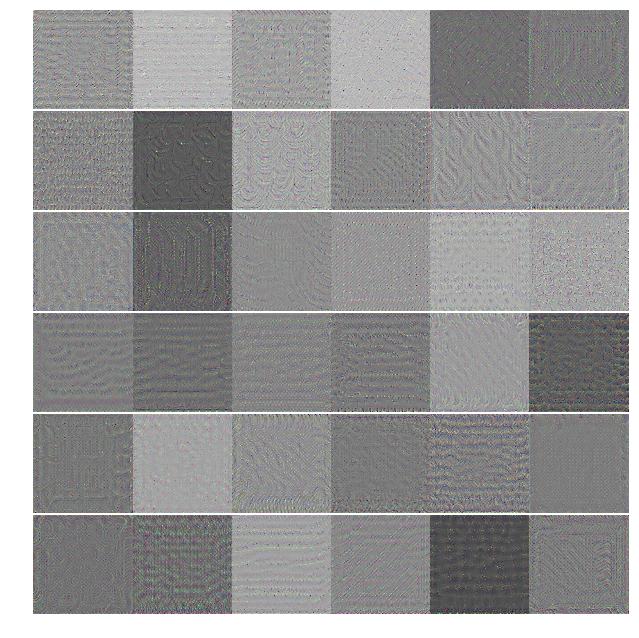

In [45]:
display_grid( dreams, how="img", img_sz=1.5)

### CNN visualization 3 - classification activation map
- idea: instead of looking at the contribution of input image to hidden features, we can look at the contribution of hidden features to the output predictions.
- implementation: 
    - for a certain feature map of shape (HEIGHT x WIDTH x CHANNELS), measure the contribution of each channel as their gradients of prediction wrt their outputs
    - convert a feature map to a heatmap by weighted sum of different channels
    - resize the heatmap and overlap with the original image
- in pytorch, to get the gradient of intermediate (non-leaf) variables :
    - before 0.2.0, you need to use GradientHook as a callback, see [discussion](https://discuss.pytorch.org/t/why-cant-i-see-grad-of-an-intermediate-variable/94/16)
    - after 0.2.0, you can just register your interest of variable graident by `variable.retain_grad()`
- pros:
- cons:

In [112]:
## VGG16 Wrapper to get the gradients of intermediate layers
class NewVgg16(nn.Module):
    def __init__(self, original_model, inspect_layers):
        super(NewVgg16, self).__init__()
        self.model = original_model
        self.inspect_layers = set(inspect_layers)
        self.inspections = {}
    def forward(self, x):
        ## repeat what a VGG16 does, but add grad infor for variables of interests
        out = x
        for i, layer in enumerate(list(self.model.features.children())):
            out = layer(out)
            if i in self.inspect_layers:
                self.inspections[i] = out
                ## retain the grad for feature map
                self.inspections[i].retain_grad()
        out = out.view([x.size(0), -1])
        out = self.model.classifier(out)
        return out
    
def plot_cam(vgg_model, img_var, ith_layer):
    
    # evaluate to predictions
    newvgg16 = NewVgg16(vgg_model, [ith_layer]).cuda()
    newvgg16.eval()
    predictions = newvgg16(img_var)
    top_classes = top_n_classes(predictions, n=5) 
    
    # for each of top predictions
    cam_imgs = []
    for i in range(5):
        loss = predictions[:, top_classes["class"].iloc[i]]
        newvgg16.zero_grad()
        loss.backward(retain_graph=True) # freeze the dynamic graph
        # gradients of predictions wrt ith feature map
        grads = newvgg16.inspections[ith_layer].grad.squeeze()
        # weights as the mean of grads
        n_channels = grads.size(0)
        map_width, map_height = grads.size(1), grads.size(2)
        weights = torch.mean(grads.view([n_channels, -1]), dim=-1).squeeze().cpu().data.numpy()
        # feature map values
        feat_map = newvgg16.inspections[ith_layer].squeeze().cpu().data.numpy()
        # heatmap as weighted sum of different channels
        heatmap = np.matmul(feat_map.reshape([n_channels,-1]).transpose([1, 0]), weights).reshape(map_width, map_height)
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
        # resize heatmap to match original
        scaled_heatmap = imresize(heatmap, (224, 224)) > 125
        # reconstruct original image from tensor
        original_image = img_var.squeeze().cpu().data.numpy().transpose([1, 2, 0])
        mean = np.array([.485, .456, .406])
        std = np.array([.229, .224, .225])
        original_image = original_image * std + mean
        # overlay prediction heatmap with original
        overlayed = np.stack([0.55*scaled_heatmap*original_image[:,:,i] + 0.05*original_image[:,:,i] 
                      for i in range(3)], axis=2)
        cam_imgs.append(overlayed)
    return cam_imgs

In [113]:
cam_imgs = plot_cam(vgg16, img_var, ith_layer=28)

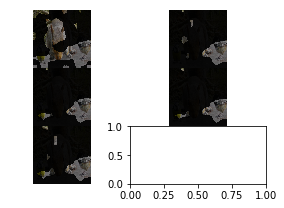

In [117]:
display_grid(np.stack(cam_imgs, axis=0), how="img")

In [100]:
newvgg16 = NewVgg16(vgg16, [28]).cuda() # last conv layer
newvgg16.eval()
logits = newvgg16(img_var)


loss = logits[:, top5["class"].iloc[4]]
newvgg16.zero_grad()
loss.backward()

In [105]:
grads = newvgg16.inspections[28].grad.squeeze()
grads.size()

torch.Size([512, 14, 14])

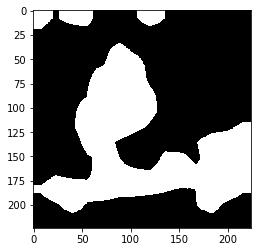

In [101]:
grads = newvgg16.inspections[28].grad.squeeze()
grads.size()
weights = torch.mean(grads.view([512, -1]), dim=-1).squeeze().cpu().data.numpy()
feat_map = newvgg16.inspections[28].squeeze().cpu().data.numpy()
heatmap = np.matmul(feat_map.reshape([512,-1]).transpose([1, 0]), weights).reshape(14, 14)
heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
scaled_heatmap = imresize(heatmap, (224, 224)) > 125
plt.imshow(scaled_heatmap, plt.cm.gray)

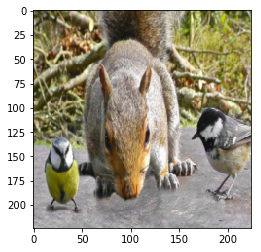

In [102]:
original_image = img_var.squeeze().cpu().data.numpy().transpose([1, 2, 0])
mean = np.array([.485, .456, .406])
std = np.array([.229, .224, .225])
original_image = original_image * std + mean
plt.imshow(original_image)

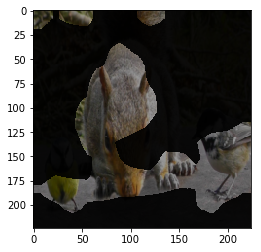

In [103]:
overlayed = np.stack([0.55*scaled_heatmap*original_image[:,:,i] + 0.05*original_image[:,:,i] 
                      for i in range(3)], axis=2)
plt.imshow(overlayed)

## Visualize seq2seq RNN